# Анализ оттока клиентов банка «Метанпром»

Цель проекта: провести исследовательский анализ данных и определить основные признаки оттока клиентов, 
проанализировать статистические гипотезы, сформировать сегменты и дать по ним рекомендации.

Входные данные: датасет, содержащий информациию о клиентах банка «Метанпром».

## Общая информация

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.io as pio

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "C:\\Users\\stupe\\python\\Bank_Metanprom\\"
df = pd.read_csv(path + 'bank_scrooge.csv')
df

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.
Колонки:
- USERID — идентификатор пользователя,
- score — баллы кредитного скоринга,
- city — город,
- gender — пол,
- age — возраст,
- equity — количество баллов собственности
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- redit_card — есть ли кредитная карта,
- last_activity — активный клиент,
- EST_SALARY — заработная плата клиента,
- churn — ушёл или нет.

В столбцах 'age' и 'balance' имеются пропуски.


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️Хорошо!</div>


## Предобработка данных

### Приведение столбцов таблицы к единообразию

In [4]:
df=df.rename(columns={'USERID':'user_id','EST_SALARY':'estimated_salary'})

Cтолбцы USERID и EST_SALARY были приведены к нижнему регистру и перезаписаны в «змеином регистре»

### Удаление пропусков

In [5]:
df.isna().sum()

user_id                0
score                  0
city                   0
gender                 0
age                   26
equity                 0
balance             2295
products               0
credit_card            0
last_activity          0
estimated_salary       0
churn                  0
dtype: int64

In [6]:
df.dropna(subset=['age'], inplace=True)

Все пропуски в столбце age удалены.

In [7]:
missing_balance = df[df['balance'].isnull()]
missing_balance_by_city = missing_balance.groupby(['city']).size().reset_index(name='count')
missing_balance_by_city

,city,count
0,Ростов,235
1,Рыбинск,586
2,Ярославль,1458


Большая часть пропусков столбца balance приходятся на клиентов из Ярославля, что объяснимо, так как общее количество клиентов их этого города больше, чем из остальных.

In [8]:
missing_balance_by_equity = missing_balance.groupby(['equity']).size().reset_index(name='count')
missing_balance_by_equity

,equity,count
0,0,2164
1,1,114
2,3,1


Почти все пропуски столбца balance имееют значение equity равное 0. Это указывает на отсутствие собственности у данных клиентов.

In [9]:
print(f'Общее количество клиентов без собственности составляет {len(df[df.equity == 0])}.')
print(f'{round(missing_balance_by_equity.values[0,1]/len(df[df.equity == 0]),3)*100}% \
пользователей без собственности имеют пропуск в столбце balance.')

Общее количество клиентов без собственности составляет 2576.
84.0% пользователей без собственности имеют пропуск в столбце balance.


Так как, видна явная ассоциация пропусков в столбце balance c значением equity = 0 и клиенты с пропущенным занчением balance составляют превалирующую часть среди всех пользователей без собственности, то я считаю неправильным удалить эти пропуски или использовать модель заполнения, так как коренным образом может исказиться смысл данного столбца. Поэтому, все пропуски будут оставлены без изменения.

### Обработка аномальных значений

In [10]:
df.sort_values(by = 'estimated_salary').head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn
8783,114221,948.0,Ярославль,Ж,26.0,1,77092.89,1,1,0,2546.30,0
2186,201407,938.0,Рыбинск,Ж,69.0,1,325483.52,3,0,1,3487.33,0
1753,161271,836.0,Ярославль,Ж,19.0,4,7703.05,4,1,1,5043.14,0
4860,193417,823.0,Ростов,Ж,64.0,2,277249.69,2,0,0,5341.50,0
1700,155567,747.0,Ростов,М,25.0,0,5750.92,1,1,0,7054.82,0
3689,219561,817.0,Ростов,М,25.0,3,121065.39,4,1,1,7522.14,0
3606,187819,839.0,Рыбинск,Ж,56.0,5,1027438.02,2,0,0,7571.80,0
2174,143340,830.0,Ярославль,Ж,72.0,2,294375.63,3,1,1,8032.18,0
9124,148483,811.0,Ярославль,Ж,75.0,5,542971.64,3,1,1,8226.26,0
9365,171110,788.0,Рыбинск,Ж,76.0,2,223228.01,2,0,0,8260.33,0


В данных отсутствуют неправдоподобно низкие значения заработной платы клиентов. Имеются значения которые сильно отличаются от минимального размера оплаты труда в данной области равному 16242 рубля. Я объясняю это тем, что у таких клиентов в качестве заработной платы указаны стипендия или пенсия.

In [11]:
df.sort_values(by = 'estimated_salary', ascending = False).head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn
4005,163640,912.0,Ярославль,М,35.0,4,15624095.80,2,0,1,1395064.45,0
4637,149430,961.0,Ярославль,М,37.0,5,4054667.81,3,0,0,1363549.52,0
4473,216422,956.0,Ярославль,М,27.0,0,NaN,1,1,0,1333687.36,0
1600,197637,785.0,Ярославль,М,41.0,0,NaN,1,1,0,1307090.18,0
5160,174746,731.0,Ярославль,Ж,30.0,0,NaN,2,1,0,1296838.08,0
149,218801,958.0,Ярославль,М,34.0,0,NaN,1,1,0,1292825.74,0
8147,135243,951.0,Ярославль,М,38.0,5,14134432.03,2,1,0,1281547.73,0
9103,123965,939.0,Ярославль,М,34.0,5,9346657.08,1,1,1,1263028.49,1
9711,193979,754.0,Ярославль,Ж,53.0,0,NaN,1,1,0,1261408.41,0
1468,162749,940.0,Ярославль,М,32.0,2,4508306.65,2,1,0,1260919.56,0


В данных также отсутствуют аномально высокие значения заработной платы клиентов.

In [12]:
print(f'Минимальный возраст клиента -  {df.age.min()}, \
а максимальный - {df.age.max()}.')

Минимальный возраст клиента -  18.0, а максимальный - 86.0.


In [13]:
df.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


Существует всего один клиент, у которого нет продуктов, удалим его, чтобы он не портил дальнейшие рассчеты.

In [14]:
df = df.query('products != 0')

### Обработка дубликатов

In [15]:
df['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [16]:
df['gender'].unique()

array(['Ж', 'М'], dtype=object)

В названии городов и обозначении полов отсутствуют неявные дубликаты

In [17]:
df[df.duplicated(subset=['user_id'], keep=False)].sort_values(by = 'user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2302,220816,934.0,Рыбинск,Ж,74.0,5,1294285.39,3,1,0,95606.80,0
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1
4216,226719,903.0,Рыбинск,Ж,63.0,0,NaN,1,1,0,138582.58,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1


Имеются 50 пар клиентов с одинаковыми user_id.

In [18]:
df_clear = df.drop_duplicates(subset=['user_id'], keep='first')

Дубликаты столбца user_id удалены.

In [19]:
print(f'Отношение очищенных данных к первоначальным составляет {round(df_clear.shape[0] / df.shape[0],3)}.')

Отношение очищенных данных к первоначальным составляет 0.995.


In [20]:
df = df_clear

## Исследовательский анализ данных

### Изучение интервалов значений характеристик, которые связаны с повышенным оттоком

In [21]:
def plot_churn_bar(df, column):
    # Функция для построения гистограммы распределения количества пользователей по категориальному столбцу
    churned_count = df[df['churn'] == 1][column].value_counts()
    stayed_count = df[df['churn'] == 0][column].value_counts()
    
    fig = go.Figure()
    # Бары для ушедших клиентов
    fig.add_trace(go.Bar(
            x=churned_count.index,
            y=churned_count.values,
            name='Ушедшие'
        ))

    # Бары для оставшихся клиентов
    fig.add_trace(go.Bar(
            x=stayed_count.index,
            y=stayed_count.values,
            name='Оставшиеся'
        ))
    fig.update_layout(
        barmode='stack',
        width=1000, 
        height=600,
        xaxis_title=column,
        yaxis_title='Количество пользователей',
        title=f'Распределение клиентов по значению признака {column}',
        xaxis = dict(
            tickmode = 'linear',
            ticktext = df[column].values
        )
    )
    
    pio.renderers.default = 'png'
    pio.write_image(fig, 'graph.png')
    fig.show()

In [22]:
def plot_churn_percent(df, column):
    # Функция для построения гистограммы распределения долей отточных и неотточных клиентов по категориальному столбцу
    churned_count = df[df['churn'] == 1][column].value_counts()
    stayed_count = df[df['churn'] == 0][column].value_counts()
    
    # Общее количество клиентов
    total_count = churned_count + stayed_count
    
    # Процент ушедших и оставшихся клиентов
    churned_percent = churned_count / total_count * 100
    stayed_percent = stayed_count / total_count * 100
    
    stayed_percent = stayed_percent.fillna(100)
    
    fig = go.Figure()
    

    # Добавляем столбцы для ушедших клиентов
    fig.add_trace(go.Bar(
         x=churned_percent.index,
         y=churned_percent.values,
         name='Ушедшие'
    ))

    # Добавляем столбцы для оставшихся клиентов
    fig.add_trace(go.Bar(
         x=stayed_percent.index,
         y=stayed_percent.values,
         name='Оставшиеся'
    ))

    fig.update_layout(
        barmode='stack',
        width=1000, 
        height=600,
        xaxis_title=column,
        yaxis_title='Процент клиентов',
        title=f'Доли клиентов по значению признака {column}',
        xaxis=dict(
            tickmode='linear',
            ticktext=df[column].values
        )
    )
    
    pio.renderers.default = 'png'
    pio.write_image(fig, 'graph.png')
    fig.show()

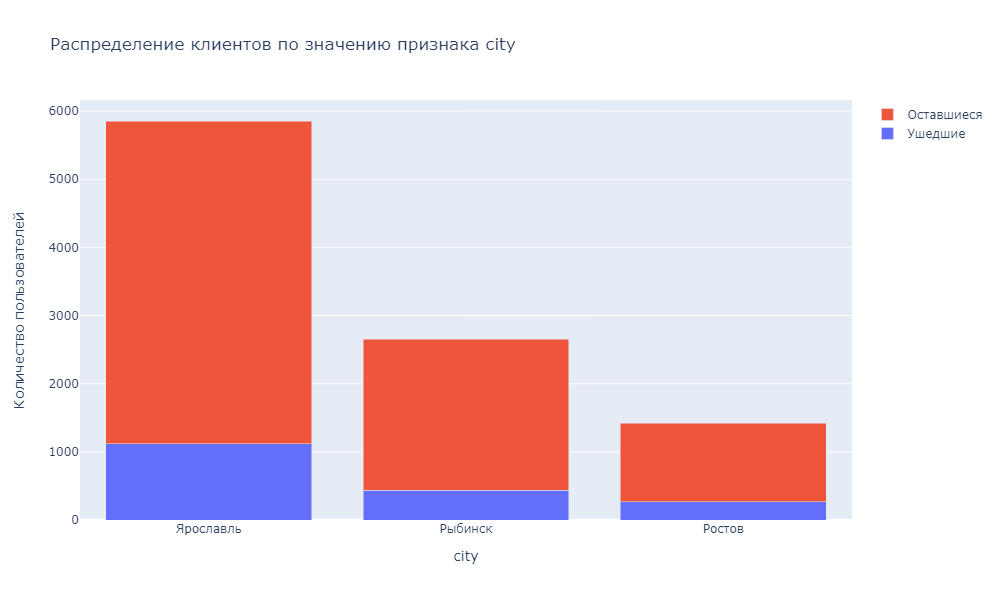

In [23]:
plot_churn_bar(df, 'city')

Больше всего в абсолютном отношении пользователей, ушедших из банка, из Ярославля.

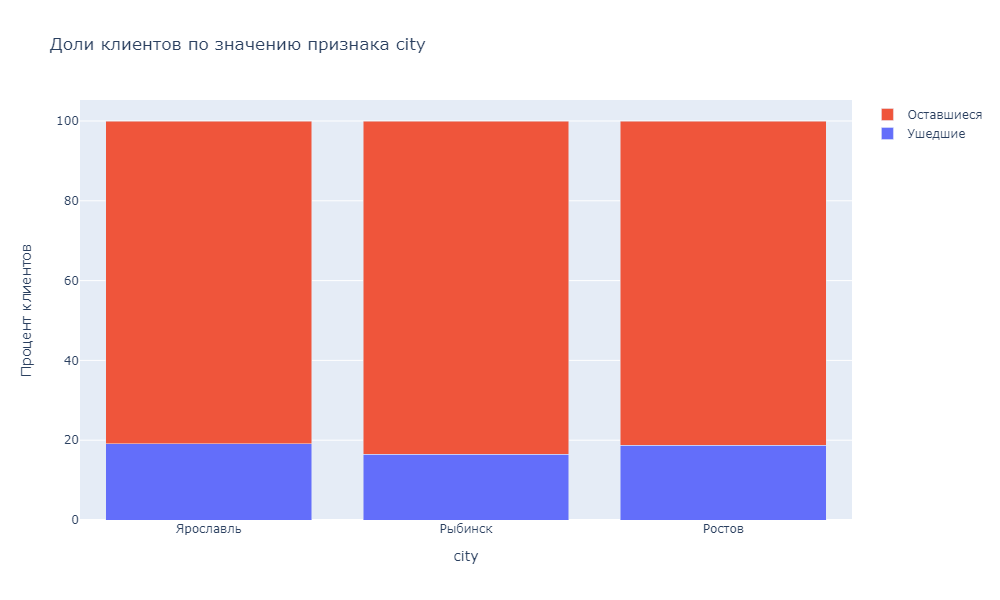

In [24]:
plot_churn_percent(df, 'city')

В процентоном соотношении нельзя выделить город лидер по оттоку клиентов.

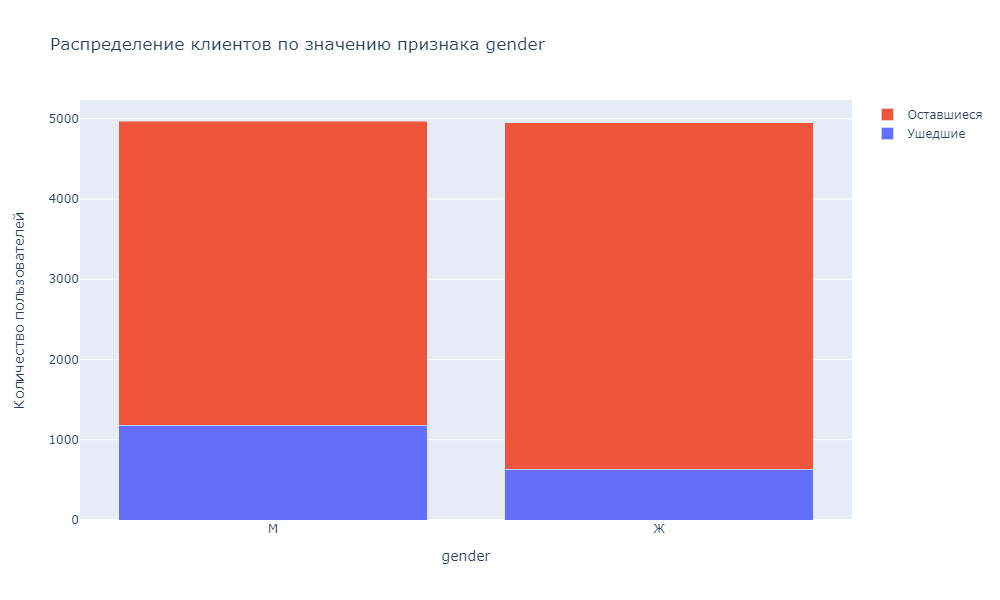

In [25]:
plot_churn_bar(df, 'gender')

Мужчин, ушедших из банка, больше чем женщин.

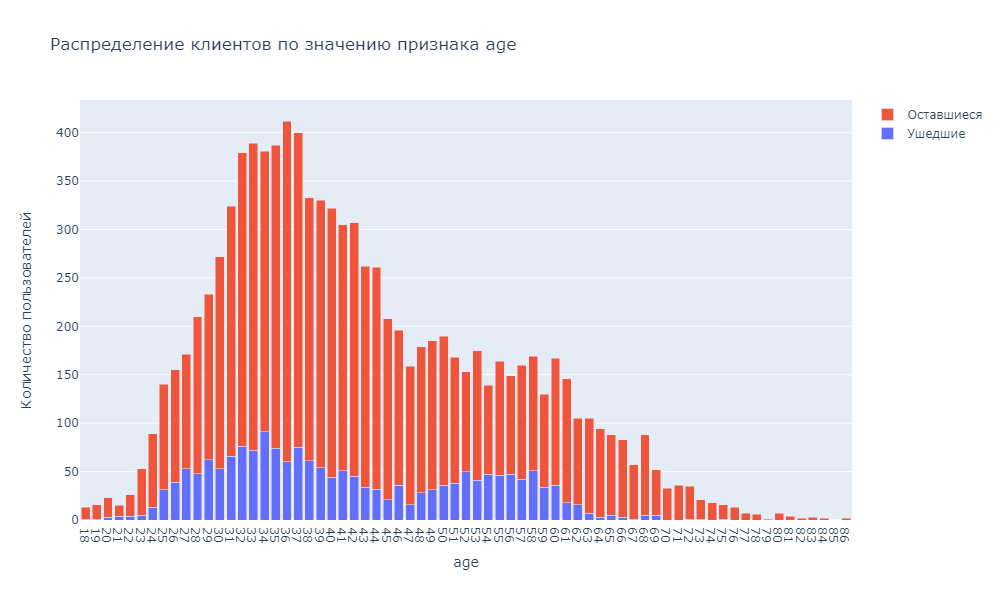

In [26]:
plot_churn_bar(df, 'age')

На графике выделяются два "горба" наиболее отточных клиентов: клиенты с 26 лет по 39 и клиенты с 50 лет по 60. Небходимо оценить процентное соотношение ушедиших и не ушедих клиентов для каждого возраста, чтобы уточнить интервалы.

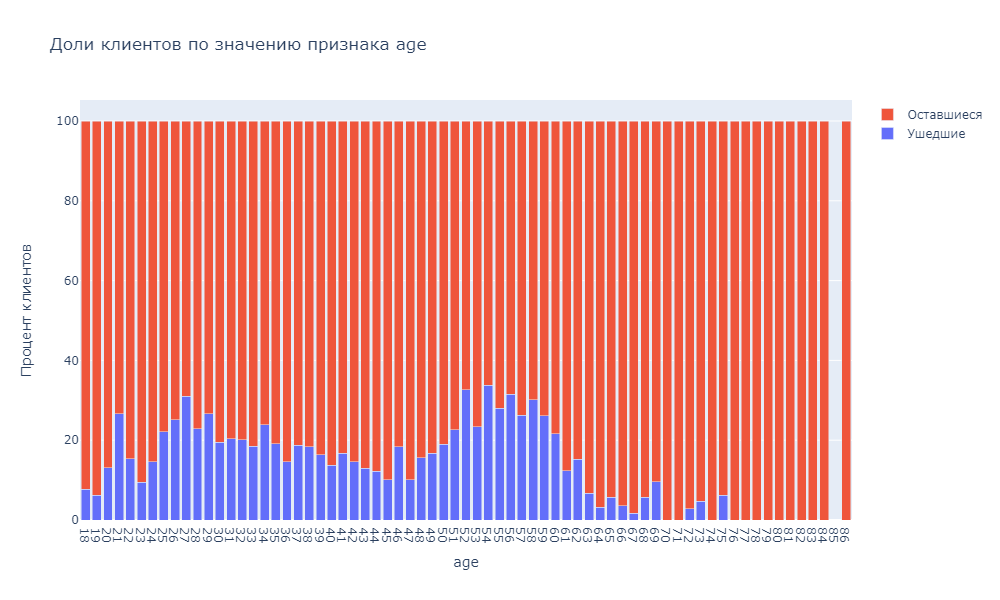

In [27]:
plot_churn_percent(df, 'age')

График долей также подтвержадет наличие двух наиболее отточных интервалов: клиенты с 26 лет по 39 и клиенты с 50 лет по 60.

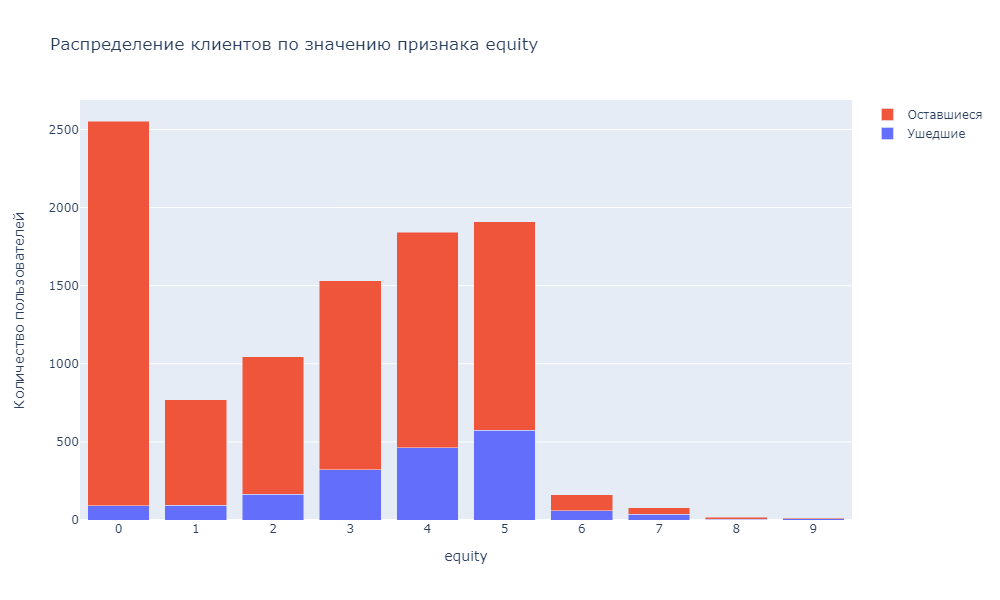

In [28]:
plot_churn_bar(df, 'equity')

Вместе с ростом общего количества клиентов, распределенным по признаку equity, заметен рост и отточных клиентов до значения equity равному 5. 

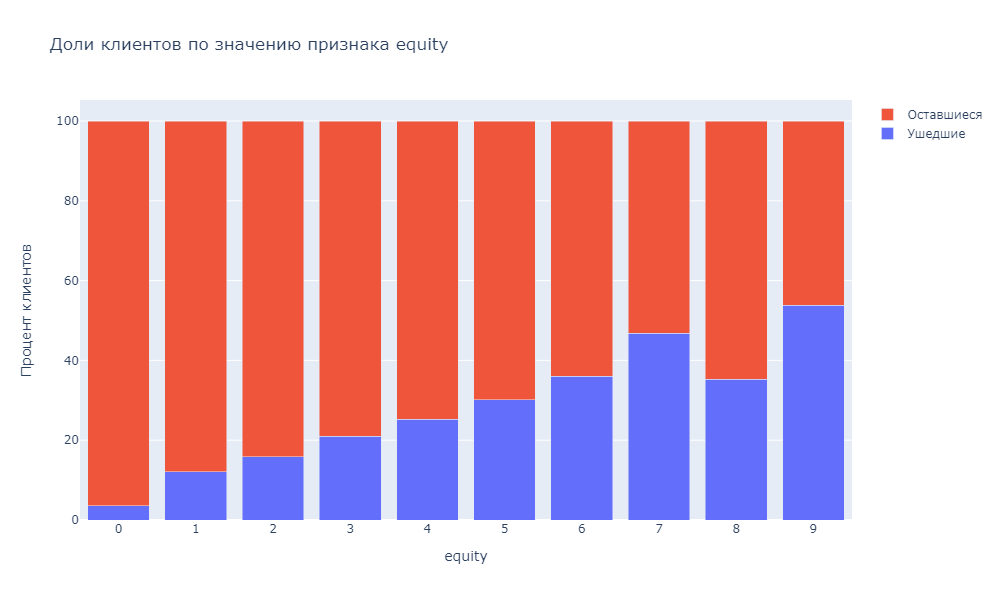

In [29]:
plot_churn_percent(df, 'equity')

Около половины клиентов, имеющих показатель equity от 7 до 9, ушли из банка. Но необходимо понимать, что общее их количество достаточно мало, что не позволяет делать по ним выводы.

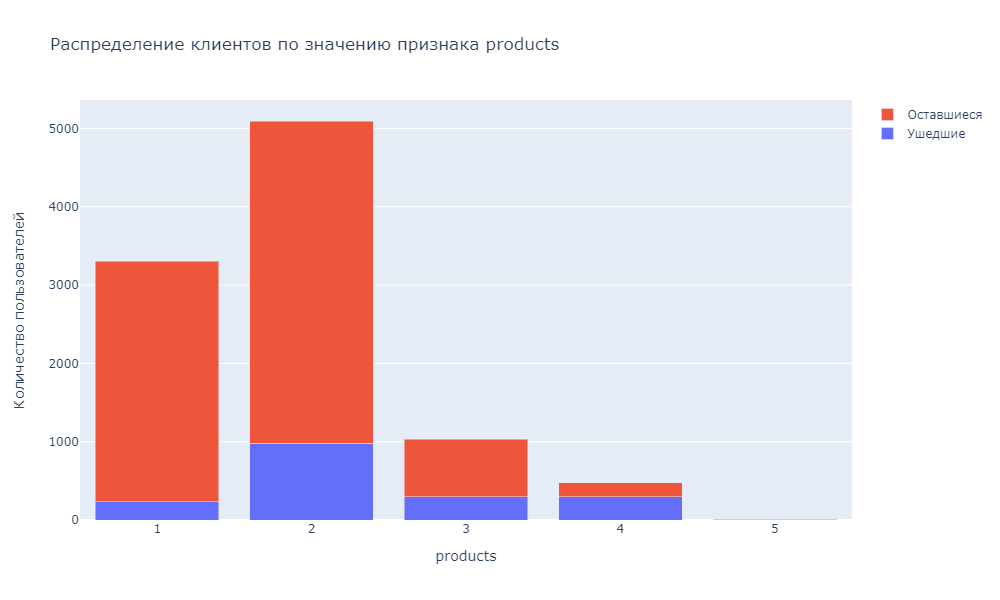

In [30]:
plot_churn_bar(df, 'products')

Наибольшее число отточных клиентов имеют 2 продукта. Клиентов, имеющих 5 продуктов, очень мало.

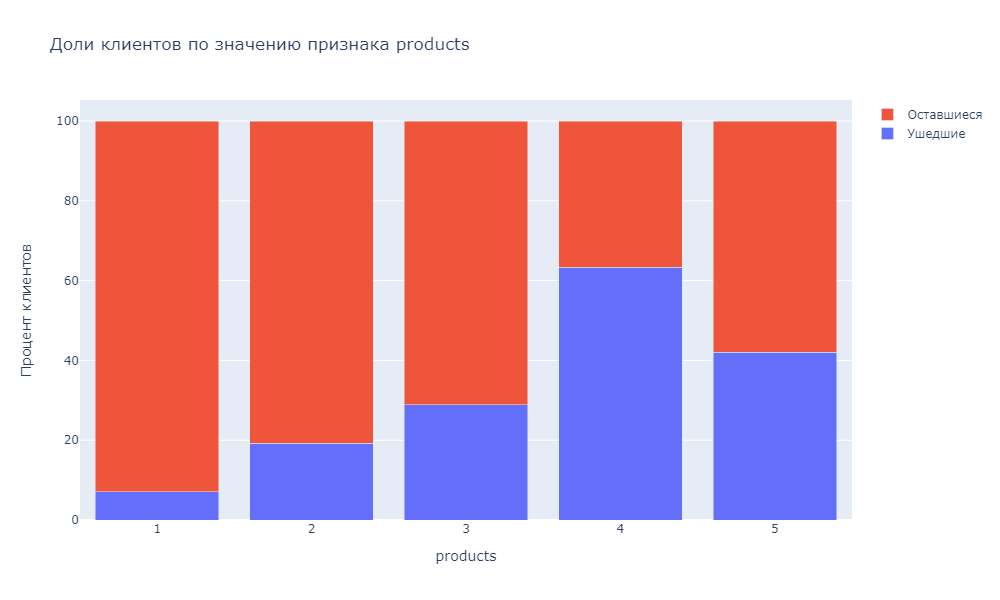

In [31]:
plot_churn_percent(df, 'products')

Чем больше у клиента продуктов, тем выше вероятность его ухода из банка.

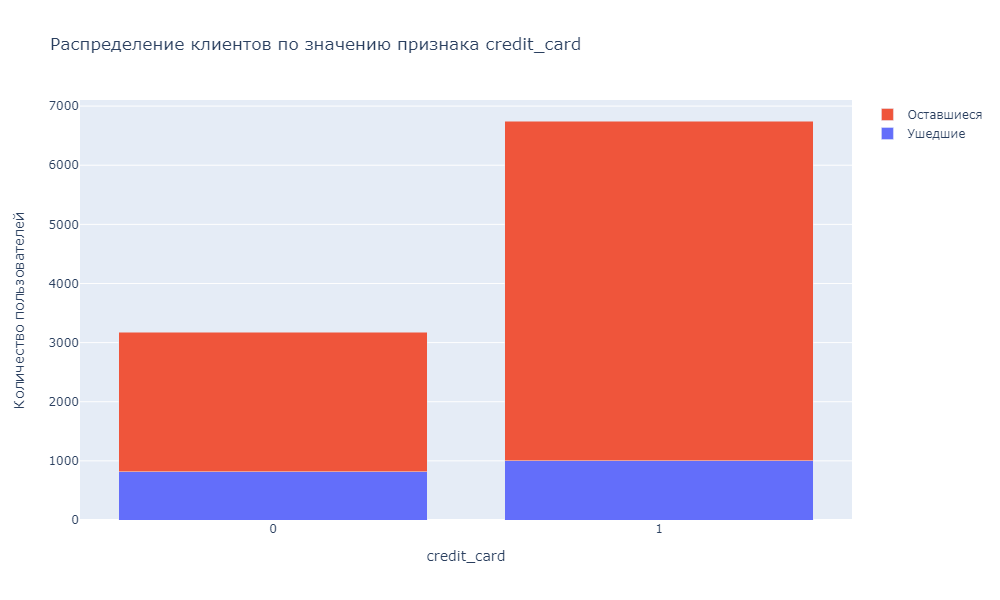

In [32]:
plot_churn_bar(df, 'credit_card')

Общее количество клиентов с кредитной картой больше, чем без нее.

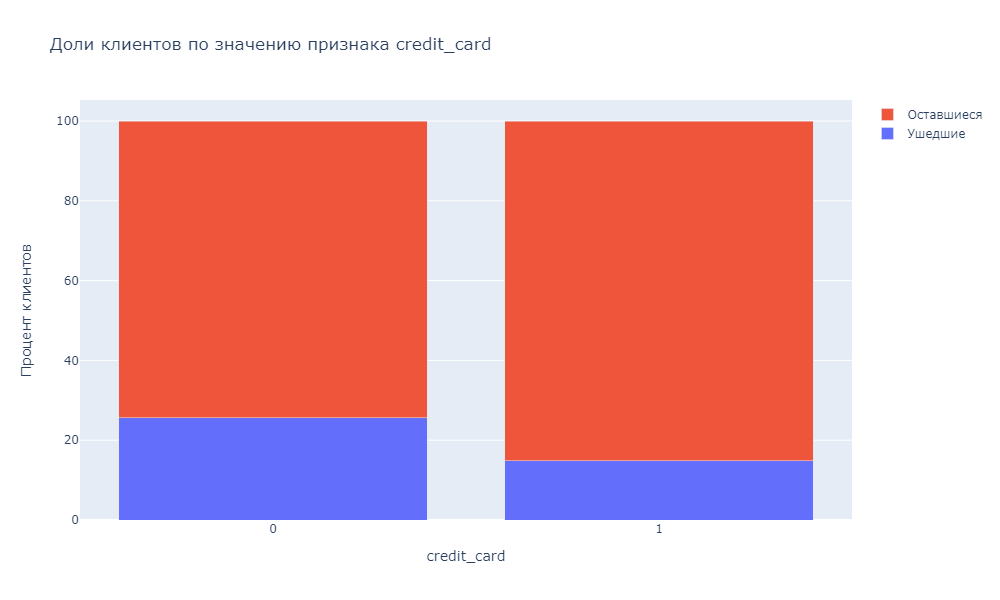

In [33]:
plot_churn_percent(df, 'credit_card')

Клиенты, не имеющие кредитную карту, чаще уходит из банка.

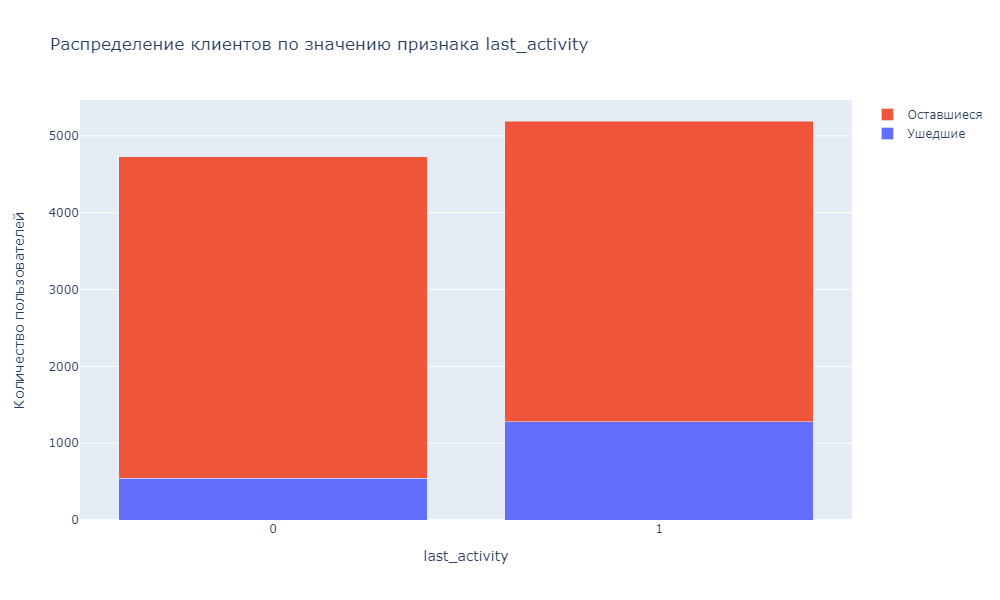

In [34]:
plot_churn_bar(df, 'last_activity')

Ушедшие клиенты чаще являются активными.

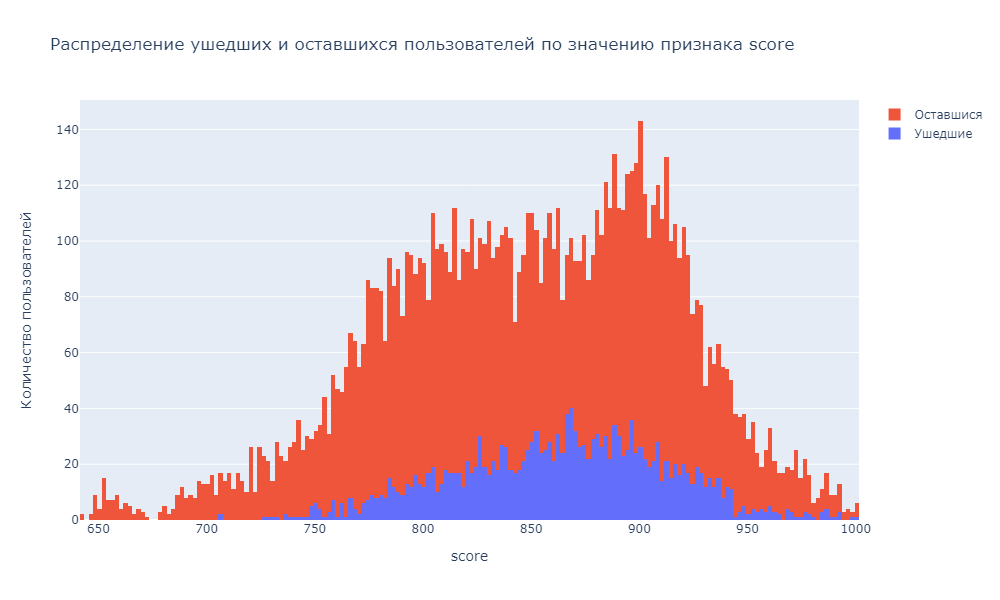

In [35]:
churned_values = df[df['churn'] == 1]['score']
stayed_values = df[df['churn'] == 0]['score']
fig = go.Figure()
    
fig.add_trace(go.Histogram(
        x=churned_values,
        name='Ушедшие',
        nbinsx=300
    ))

fig.add_trace(go.Histogram(
         x=stayed_values,
         name='Оставшися',
         nbinsx=300
     ))

fig.update_layout(
        barmode='stack',
        width=1000, 
        height=600,
        xaxis_title='score',
        yaxis_title='Количество пользователей',
        title=f'Распределение ушедших и оставшихся пользователей по значению признака score'
    )            

Практически отсутствуют ушедшие пользователи с низким значением кредитного скоринга. В остальном, распределения значениий кредитного скоринга ушедших и оставшихся пользовтелей, похожи.

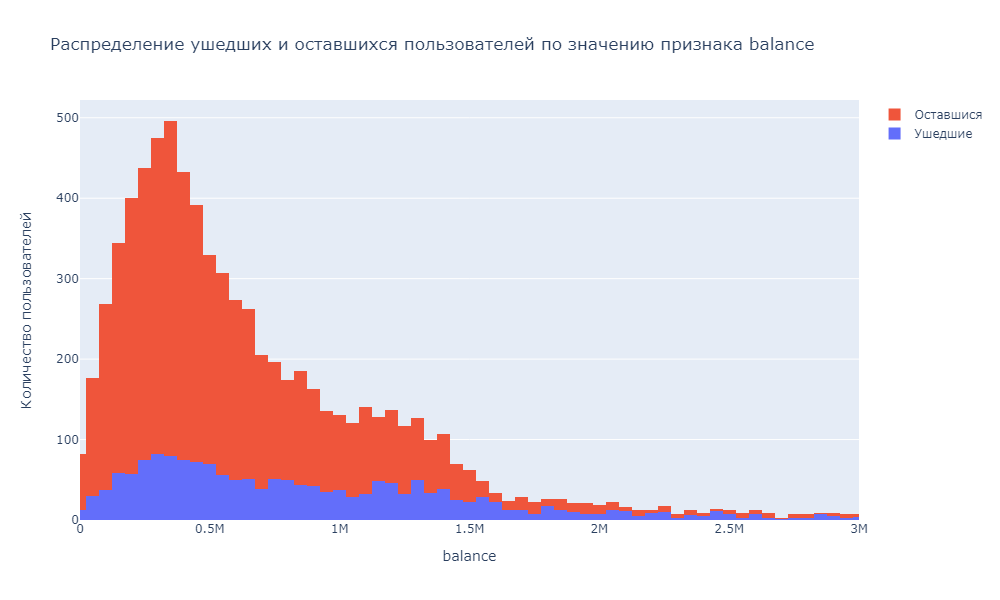

In [36]:
churned_values = df[df['churn'] == 1]['balance']
stayed_values = df[df['churn'] == 0]['balance']
fig = go.Figure()
    
fig.add_trace(go.Histogram(
        x=churned_values,
        name='Ушедшие',
        nbinsx=5000
    ))

fig.add_trace(go.Histogram(
         x=stayed_values,
         name='Оставшися',        
         nbinsx=5000
     ))

fig.update_layout(
        barmode='stack',
        width=1000, 
        height=600,
        xaxis_title='balance',
        yaxis_title='Количество пользователей',
        title=f'Распределение ушедших и оставшихся пользователей по значению признака balance',
        xaxis=dict(
            range=[0, 3000000]
        )
    )

Ушедшие пользователи имеют более плавное распределение баланса на счете, чем оставшиеся, у которых есть ярко выраженный пик возле 400 тысяч. Начиная с показателя баланса около 900000 рублей заметен рост доли отточных клиентов от общего числа клиентов с такии же балансом.

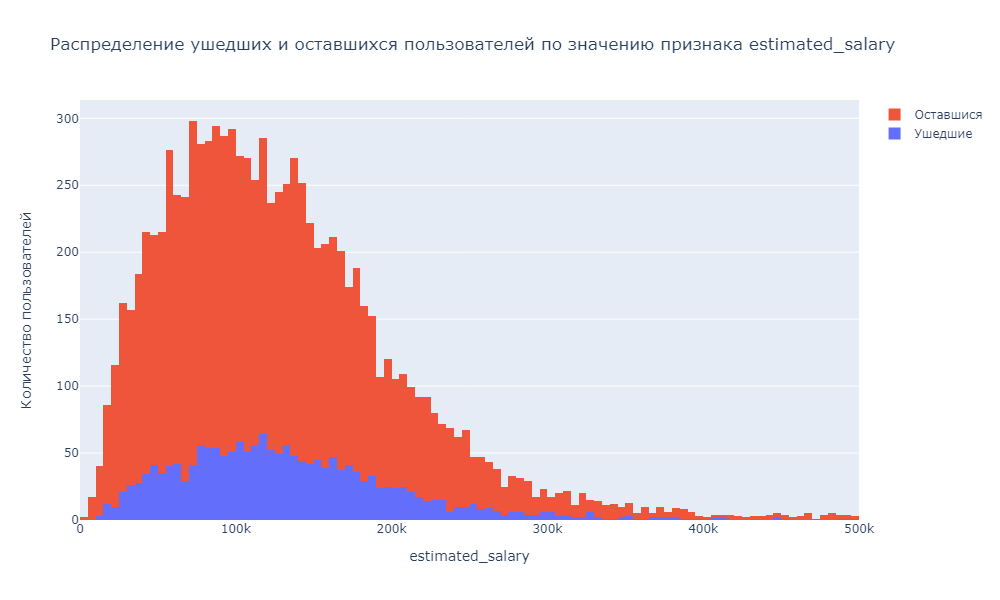

In [37]:
churned_values = df[df['churn'] == 1]['estimated_salary']
stayed_values = df[df['churn'] == 0]['estimated_salary']
fig = go.Figure()
    
fig.add_trace(go.Histogram(
        x=churned_values,
        name='Ушедшие',
        nbinsx=500
    ))

fig.add_trace(go.Histogram(
         x=stayed_values,
         name='Оставшися',        
         nbinsx=500
     ))

fig.update_layout(
        barmode='stack',
        width=1000, 
        height=600,
        xaxis_title='estimated_salary',
        yaxis_title='Количество пользователей',
        title=f'Распределение ушедших и оставшихся пользователей по значению признака estimated_salary',
        xaxis=dict(
            range=[0, 500000]
        )
    )

Распределения значениий заработной платы ушедших и оставшихся пользовтелей достаточной похожи.

### Создание портрета клиента, склонного уходить из банка

Исходя из всех построенных графиков, можно составить следующий портрет клиента, склонного уходить из банка:

- Мужчина
- Возрастом с 26 лет по 39 и с 50 лет по 60
- Имеющий от 2 до 4 продуктов
- Имеющий на балансе более 900000 рублей
- Яляющийся активным клиентом

## Проверка гипотез

Так как размеры выборок несопоставимы, то для проверки гипотез можно использовать непараметрический тест Манна-Уитни.

Пороговый уровень статистической значимости - 0.05.

### Медианный доход ушедших клиентов отличается от медианного дохода оставшихся клиентов

Нулевая гипотеза - Медианный доход ушедших клиентов равен медианному доходу оставшихся клиентов.

Альтернативная - Медианный доход ушедших клиентов отличается от медианного дохода оставшихся клиентов.

In [38]:
churned_salaries = df[df['churn'] == 1]['estimated_salary']
stayed_salaries = df[df['churn'] == 0]['estimated_salary']

statistics, p_value = stats.mannwhitneyu(churned_salaries, stayed_salaries, alternative='two-sided')

# Вывод результатов
alpha = 0.05

if p_value < alpha:
    print(f'p-значение: {p_value:.4f}. Отвергаем нулевую гипотезу.')
else:
    print(f'p-значение: {p_value:.4f}. Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.0002. Отвергаем нулевую гипотезу.


### Медианный кредитный рейтинг ушедших клиентов равен медианному кредитному рейтингу оставшихся клиентов.

Нулевая гипотеза - Медианный кредитный рейтинг ушедших клиентов равен медианному кредитному рейтингу оставшихся клиентов.

Альтернативная - Медианный кредитный рейтинг ушедших клиентов отличается от медианного кредитного рейтинга оставшихся клиентов.

In [39]:
churned_clients  = df[df['churn'] == 1]['score']
remaining_clients  = df[df['churn'] == 0]['score']

statistics, p_value = stats.mannwhitneyu(churned_clients, remaining_clients, alternative='two-sided')

# Вывод результатов
alpha = 0.05

if p_value < alpha:
    print(f'p-значение: {p_value}. Отвергаем нулевую гипотезу.')
else:
    print(f'p-значение: {p_value}. Не получилось отвергнуть нулевую гипотезу.')

p-значение: 5.9541380859275425e-22. Отвергаем нулевую гипотезу.


Для обоих тестов мы можем отвергнуть нулевые гипотезы.

## Сегментация

In [40]:
bank_churn_level = round(df.churn.sum()/len(df)*100,2)
print(f'Уровень оттока по банку равен {bank_churn_level}%')

Уровень оттока по банку равен 18.32%


### Сегмент 1 

Первый сегмент будут составлять мужчины в возрасте от 26 до 39 лет или от 50 до 60 лет, имеющие от 2 до 4 продуктов, и имеющие на балансе более 900000 рублей.

In [41]:
segment_1 = df.query('gender == "М" and (26 <= age <= 39 or 50 <= age <= 60) and (2 <= products <= 4 ) and balance >= 900000')

size_segment_1 = len(segment_1)
churn_segment_1 = segment_1['churn'].sum()

print(f'Объем первого сегмента равен {size_segment_1} человек, из них {churn_segment_1} являются отточными.')

segment_1_churn_level = round(churn_segment_1/size_segment_1*100,2)
print(f'Уровень оттока по первому сегменту равен {segment_1_churn_level}%.')

Объем первого сегмента равен 646 человек, из них 381 являются отточными.
Уровень оттока по первому сегменту равен 58.98%.


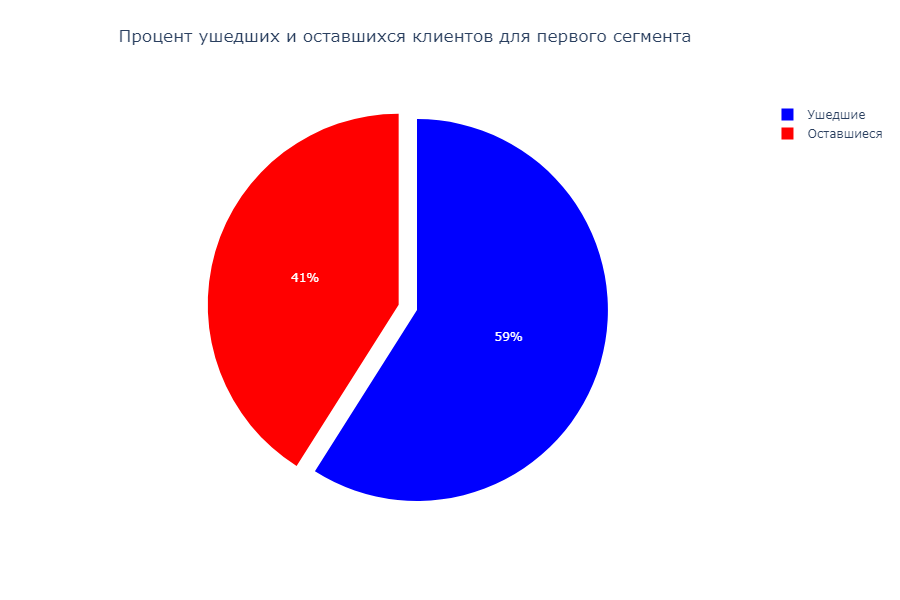

In [42]:
fig = go.Figure(data=[go.Pie(labels=['Оставшиеся','Ушедшие'],
                             values=[size_segment_1 - churn_segment_1, churn_segment_1], 
                             pull = [0.1, 0],
                             marker=dict(colors=['red', 'blue'])
                            )]) 
fig.update_layout(title={'text':'Процент ушедших и оставшихся клиентов для первого сегмента',
                         'y': 0.95,
                         'x': 0.45, 
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=900, 
                  height=600)
fig.show()

### Сегмент 2

Второй сегмент будут составлять мужчины в возрасте от 26 до 39 лет или от 50 до 60 лет, имеющие от 2 до 4 продуктов, и являющиеся активными.

In [43]:
segment_2 = df.query('gender == "М" and (26 <= age <= 39 or 50 <= age <= 60) and (2 <= products <= 4 ) and last_activity == 1')

size_segment_2 = len(segment_2)
churn_segment_2 = segment_2['churn'].sum()

print(f'Объем второго сегмента равен {size_segment_2} человек, из них {churn_segment_2} являются отточными.')

segment_2_churn_level = round(churn_segment_2/size_segment_2*100,2)
print(f'Уровень оттока по второму сегменту равен {segment_2_churn_level}%.')

Объем второго сегмента равен 1095 человек, из них 503 являются отточными.
Уровень оттока по второму сегменту равен 45.94%.


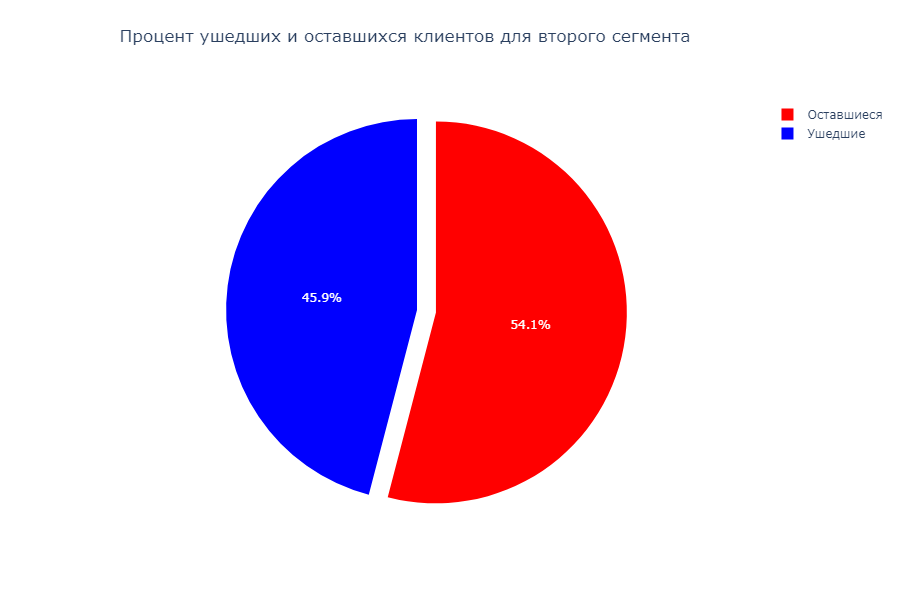

In [44]:
fig = go.Figure(data=[go.Pie(labels=['Оставшиеся','Ушедшие'],
                             values=[size_segment_2 - churn_segment_2, churn_segment_2,], 
                             pull = [0.1, 0],
                             marker=dict(colors=['red', 'blue'])
                             )]) 
fig.update_layout(title={'text':'Процент ушедших и оставшихся клиентов для второго сегмента',
                         'y': 0.95,
                         'x': 0.45, 
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=900, 
                  height=600)
fig.show()

### Выводы по главе

Уровни оттока для первого и второго сегмента выше уровня оттока по банку на 40 и 28 процентных пунктов соответственно. Приоритетным к вниманию следует отнести первый сегмент, а за ним второй.

## Выводы по проекту

В процессе выполнения проекта были проделаны следующие шаги:
- Выполнена предобработка данных
- Произведен исследовательский анализ данных
- Выдвинуты и проверены 2 статистические гипотезы
- Сформированы 2 сегмента, связанные с повышенным оттоком.

В процессе исследовательского анализа данных были построенные диаграммы распределения ушедших и оставшихся клиентов, выделены интервалы и характеристики, связанные с повышенным оттоком, и составлен портрет клиента, склонного уходить из банка.

Обе статистические гипотезы выявили статистическую разницу между ушедшими и оставшимися клиентами.

Два выделенных сегмента показывают достаточно высокий уровень оттока клиентов.

### Рекомендации

Я бы выделил следующие рекомендации по отношению к отточным клиентам:

- Необходимо повысить уровень удовлетворенности клиентов в каждом сегменте. Например, можно использовать обратную связь клиентов, чтобы понять, какие аспекты нуждаются в улучшении.

- Необходимо разработать персонализированные стратегии, чтобы удерживать клиентов в каждом сегменте. Нужно учесть особенности и потребности клиентов в каждом сегменте и, возможно, предоставить им специальные предложения.

- Необходимо исследовать конкурентные предложения и стратегии, чтобы понять, почему клиенты уходят к конкурентам. 

- Необходимо разработать стратегии по привлечению новых клиентов в каждом сегменте. Нужно исследовать источники привлечения новых клиентов, а также проводить рекламные кампании, которые могут привлечь клиентов.

## Приложение

### Презентация

https://drive.google.com/file/d/1Ew1MrEdP7wvfvfH27pV5k2leDZlMGZPb/view?usp=sharing

### Дашборд

https://public.tableau.com/app/profile/yaroslav.brodnev/viz/Dashboard_for_Metanprom/Dashboard1?publish=yes